In [1]:
import numpy as np
import os
import itertools
import time
from operator import and_

import torch
from torch.utils.data import DataLoader

from qtorch.quant import Quantizer, quantizer
from qtorch.optim import OptimLP
from torch.optim import SGD
from qtorch import FloatingPoint
from qtorch.auto_low import sequential_lower
from pathlib import Path

import math
from scipy.stats import norm # for GP
from scipy.stats import sem # standard error

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

import itertools
import sys
sys.path.append('..')
import train_func as tf

import mkl
mkl.set_num_threads(1)

import multiprocessing as mp

import apgpy
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

from experiment_design import pivot_columns, greedy_stepwise_selection
from scipy.stats import sem
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

In [2]:
def relative_error(mtx_true, mtx_pred):
    return np.linalg.norm(mtx_true - mtx_pred) / np.linalg.norm(mtx_true)

In [3]:
# Metric 1: convergence

def get_closest_dist(true_all, pred):
    """
    true_all: a (n_points, dim_points) array. 
    pred: the single point to compute distance from.
    """
    dist_all = []
    for ref in true_all:
        dist_all.append(np.linalg.norm(pred - ref))
    return np.min(dist_all)    

def get_convergence_metric(error_true_at_true_frontier, memory_true_at_true_frontier, 
                          error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                          range_error_true, range_error_pred, range_memory):
    error_true_at_true_frontier_rescaled = error_true_at_true_frontier / range_error_true
    error_pred_at_pred_frontier_rescaled = error_pred_at_pred_frontier / range_error_pred
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / range_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / range_memory
    
    costs_at_true_frontier = np.hstack((error_true_at_true_frontier_rescaled.reshape(-1, 1), 
                                        memory_true_at_true_frontier_rescaled.reshape(-1, 1)))
    costs_at_pred_frontier = np.hstack((error_pred_at_pred_frontier_rescaled.reshape(-1, 1), 
                                        memory_true_at_pred_frontier_rescaled.reshape(-1, 1)))
    
#     dists = np.full(len(error_pred_at_pred_frontier), np.nan)
    dists = []
    for cost_pred in costs_at_pred_frontier:
        dists.append(get_closest_dist(costs_at_true_frontier, cost_pred))
#     return dists
    return np.average(dists)


# Metric 2: hypervolume difference

def hypervolume(x_all, y_all, x_max, y_max):
    x_all = np.array(x_all)
    y_all = np.array(y_all)
    
    assert all(x_all <= x_max), "there are x values larger than x_max"
    assert all(y_all <= y_max), "there are y values larger than y_max"
    assert len(x_all) == len(y_all)
#     assert all((np.diff(x_all) > 0) != (np.diff(y_all) > 0)) # XOR
    x_all_sorted = np.sort(x_all)
    y_all_rev_sorted = -np.sort(-y_all)
    y_all_rev_sorted_diff = -np.diff(y_all_rev_sorted)
    y_all_rev_sorted_diff = np.insert(y_all_rev_sorted_diff, 0, y_max-y_all_rev_sorted[0])
    return np.sum([(x_max - x_all[i]) * y_all_rev_sorted_diff[i] for i in range(len(x_all))])
    

def hypervolume_difference(error_true_at_true_frontier, memory_true_at_true_frontier, 
                error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                range_error_true, range_error_pred, range_memory, 
                max_error, max_memory):
    error_true_at_true_frontier_rescaled = error_true_at_true_frontier / range_error_true
    error_pred_at_pred_frontier_rescaled = error_pred_at_pred_frontier / range_error_pred
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / range_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / range_memory
    max_error_rescaled = max_error / range_error_true
    max_memory_rescaled = max_memory / range_memory
    
    hypervolume_true = hypervolume(memory_true_at_true_frontier_rescaled, error_true_at_true_frontier_rescaled,
                                   max_memory_rescaled, max_error_rescaled)
    
    hypervolume_pred = hypervolume(memory_true_at_pred_frontier_rescaled, error_pred_at_pred_frontier_rescaled,
                                   max_memory_rescaled, max_error_rescaled)
    
    return np.abs(hypervolume_pred - hypervolume_true)

def hypervolume_difference_no_error_scaling(error_true_at_true_frontier, memory_true_at_true_frontier, 
                error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                max_error, max_memory):
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / max_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / max_memory    
    
    hypervolume_true = hypervolume(memory_true_at_true_frontier_rescaled, error_true_at_true_frontier,
                                   1, max_error)
    
    hypervolume_pred = hypervolume(memory_true_at_pred_frontier_rescaled, error_pred_at_pred_frontier,
                                   1, max_error)
    
    return np.abs(hypervolume_pred - hypervolume_true)
    

In [4]:
data_path = os.path.join(Path(os.getcwd()).parent.absolute(), 'data')

accuracy_matrix = np.load(os.path.join(data_path, 'acc_matrix_res64_all.npy'))
memory_matrix = np.load(os.path.join(data_path, 'mem_matrix_full.npy'))
error_matrix = 1 - accuracy_matrix

idx_dataset_to_remove = 28 # remove full CIFAR100
memory_matrix = np.delete(memory_matrix, idx_dataset_to_remove, axis=0)
error_matrix = np.delete(error_matrix, idx_dataset_to_remove, axis=0)

In [5]:
def approx_matrix_rank(a, threshold=0.03):
    """Compute approximate rank of a matrix.
    Args:
        a (np.ndarray):    Matrix for which to compute rank.
        threshold (float): All singular values less than threshold * (largest singular value) will be set to 0
    Returns:
        int: The approximate rank of a.
    """
    s = np.linalg.svd(a, compute_uv=False)
    rank = s[s >= threshold * s[0]]
    return len(rank)

In [6]:
def pca(a, rank=None, threshold=None):
    """Solves: minimize ||A_XY||^2 where ||.|| is the Frobenius norm.
    Args:
        a (np.ndarray):    Matrix for which to compute PCA.
        threshold (float): Threshold specifying approximate rank of a.
        rank (int):        The approximate rank.
    Returns:
        x, y (np.ndarray): The solutions to the PCA problem.
        vt (np.ndarray):   Transpose of V as specified in the singular value decomposition.
    """
    assert (threshold is None) != (rank is None), "Exactly one of threshold and rank should be specified."
    if threshold is not None:
        rank = approx_matrix_rank(a, threshold)
    # std = np.std(a, axis=0)
    u, s, vt = svds(a, k=rank)

    nonzero_pos = np.where(s > 0)[0]
    s = s[nonzero_pos]
    u = u[:, nonzero_pos]
    vt = vt[nonzero_pos, :]

    u = np.fliplr(u)
    s = np.flipud(s)
    vt = np.flipud(vt)
    # sigma_sqrt = np.diag(np.sqrt(s))
    # x = np.dot(u, sigma_sqrt).T
    # # y = np.dot(np.dot(sigma_sqrt, vt), np.diag(std))
    # y = np.dot(sigma_sqrt, vt)

    sigma = np.diag(s)
    x = np.dot(u, sigma).T
    y = vt
    return x, y, vt

In [7]:
# low precision configurations
low_formats = [['Representation_Float', '5', 1],['Representation_Float', '6', 2],
               ['Representation_Float', '7', 3],['Representation_Float', '8', 4],
               ['Representation_Float', '6', 1],['Representation_Float', '7', 2],
               ['Representation_Float', '8', 3],['Representation_Float', '9', 4],
               ['Representation_Float', '7', 1],['Representation_Float', '8', 2],
               ['Representation_Float', '9', 3]]

high_formats = [['Representation_Float', '14', 7],['Representation_Float', '16', 9],
                ['Representation_Float', '18', 11],['Representation_Float', '15', 7],
                ['Representation_Float', '17', 9],['Representation_Float', '19', 11],
                ['Representation_Float', '16', 7],['Representation_Float', '18', 9],
                ['Representation_Float', '20', 11]]

lp_configs = list(itertools.product(low_formats, high_formats))

In [8]:
# get dataset-precision combinations

settings_all = []

for i in range(error_matrix.shape[0]):
    for j in range(error_matrix.shape[1]):
        settings_all.append((i, lp_configs[j]))

settings_all = np.array(settings_all)

In [11]:
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

def uniform_sampling(ratio, matrix, seed=0):
    sampled_matrix = matrix.copy()
    np.random.seed(seed)
    mask = np.random.choice([True, False], matrix.shape, p=[ratio, 1-ratio])
    sampled_matrix[np.invert(mask)] = np.nan
    return sampled_matrix, mask.astype(int)

def weighted_softimpute(X, M, W, lmbda, max_rank=None,
                        min_value=None, max_value=None,
                        apg_max_iter=2500, apg_eps=1e-6,
                        apg_use_restart=True):
    m = X.shape[0]
    n = X.shape[1]

    def prox(Z, t):
        Z = Z.reshape(m, n)

        # singular value shrinkage
        if max_rank is None:
            U, S, VT = svds(Z, k=min(Z.shape)-1)
            U = np.fliplr(U)
            S = np.flipud(S)
            VT = np.flipud(VT)

        else:
            U, S, VT = randomized_svd(Z, max_rank)
        S = np.maximum(S - lmbda*t, 0)
        Z = np.dot(U * S, VT)

        # clip values
        if min_value is not None:
            mask = Z < min_value
            if mask.sum() > 0:
                Z[mask] = min_value
        if max_value is not None:
            mask = Z > max_value
            if mask.sum() > 0:
                Z[mask] = max_value

        return Z.flatten()

    M_one_mask = (M == 1)
    masked_weights = W[M_one_mask]
    masked_X = X[M_one_mask]
    def grad(Z):
        grad = np.zeros((m, n))
        grad[M_one_mask] = (Z.reshape(m, n)[M_one_mask] - masked_X) * masked_weights
        return grad.flatten()

    X_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True).reshape((m, n))
    return X_hat

def NormalizeData(data, min_value=0, max_value=1):
    pos = (data - np.min(data)) / (np.max(data) - np.min(data))    
    return min_value + pos * (max_value - min_value)

def nonuniform_sampling(sampling_prob, matrix, seed=0):
    sampled_matrix = matrix.copy()
    np.random.seed(seed)
    mask = (np.random.uniform(0, 1, sampling_prob.shape) < sampling_prob)
    sampled_matrix[np.invert(mask)] = np.nan
    return sampled_matrix, mask.astype(int)

# in a single ED case, plot the roles of different points

In [12]:
memory_matrix_part = memory_matrix
error_matrix_part = error_matrix

# CIFAR-10 as meta-test
error_matrix_part_train = error_matrix_part[1:]
error_matrix_part_test = error_matrix_part[0]
memory_matrix_part_train = memory_matrix_part[1:]
memory_matrix_part_test = memory_matrix_part[0]

memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
error_matrix_part_train_flattened = error_matrix_part_train.flatten()
memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
error_matrix_part_test_flattened = error_matrix_part_test.flatten()

# memory_cap = np.inf
# memory_cap = np.median(memory_matrix_part_test.flatten())
memory_cap = 275
print("memory cap: {}".format(memory_cap))
#     sampling_scheme = 'no_sampling'
sampling_scheme = 'unif'
#     sampling_scheme = 'non_unif'

is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))

error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]

if sampling_scheme == 'unif':
    # Case 1: sample and complete the meta-training matrix
    ratio = 0.2
    error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

    W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)
    rank = 5
    error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                            M_train_unif, W_train_unif, 
                                           lmbda=.1, max_rank=rank, min_value=0, max_value=1)

    error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]    
    rank = 5
    U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_unif_trunc)

elif sampling_scheme == 'no_sampling':
    # Case 2: use original meta-training matrix
    error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
    rank = 5
    U, S, Vt = np.linalg.svd(error_matrix_part_train_trunc)

elif sampling_scheme == 'non_unif':
    max_prob = 0.2
    inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
    inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
    sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
    seed = 0
    error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                             error_matrix_part, seed=seed)

    W_train_non_unif = 1/sampling_prob_non_unif
    error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                          M_train_non_unif, W_train_non_unif, 
                                   lmbda=.1, max_rank=5, min_value=0, max_value=1)

    error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test]    
    rank = 5
    U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_non_unif_trunc)   


Y_ed = Vt[:rank, :]

initialization = pivot_columns(Y_ed, rank=rank, columns_to_avoid=None)

memory cap: 275


In [13]:
n_greedy = 1

selected = greedy_stepwise_selection(Y_ed, initialization, n_greedy, columns_to_avoid=None, verbose=False)
xt_pred_ed = np.linalg.lstsq(Y_ed[:, selected].T, error_matrix_part_test_trunc[selected], rcond=None)[0]
error_matrix_part_test_pred_unif_trunc = xt_pred_ed @ Y_ed
#     print(np.linalg.norm(error_matrix_part_test_pred_unif_trunc - error_matrix_part_test))

costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
is_efficient_test = is_pareto_efficient_dumb(costs_test)

# true PF
indices_true_test_frontier = np.where(is_efficient_test)[0]
error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]

# predicted PF
costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc.reshape(-1, 1)))
is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc[indices_pred_test_frontier]
memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]

selected_in_original = np.arange(error_matrix_part_test.shape[0])[is_valid_test][selected]
not_valid_in_original = np.array(list(set(np.arange(error_matrix_part_test.shape[0])) - set(np.arange(error_matrix_part_test.shape[0])[is_valid_test])))
is_efficient_test_pred_in_original = np.full(error_matrix_part_test.shape[0], False)
is_efficient_test_pred_in_original[is_valid_test] = is_efficient_test_pred

In [14]:
is_not_efficient_test_pred = np.array(list(set(np.arange(error_matrix_part_test.shape[0])) - set(is_efficient_test_pred_in_original) - set(not_valid_in_original)))

memory_single_non_eff_pred = memory_matrix_part_test[is_not_efficient_test_pred]
error_single_non_eff_pred = error_matrix_part_test[is_not_efficient_test_pred]

memory_single_selected = memory_matrix_part_test[selected_in_original]
error_single_selected = error_matrix_part_test[selected_in_original]
memory_single_eff_pred = memory_matrix_part_test[is_efficient_test_pred_in_original]
error_single_eff_pred = error_matrix_part_test[is_efficient_test_pred_in_original]

memory_single_not_valid = memory_matrix_part_test[not_valid_in_original]
error_single_not_valid = error_matrix_part_test[not_valid_in_original]

memory_matrix_part_test_exhaustive = np.array(list(map(and_, memory_matrix_part_test >= 260, memory_matrix_part_test < 275)))

([<matplotlib.axis.YTick at 0x7fc0a135dfd0>,
 <a list of 2 Text yticklabel objects>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


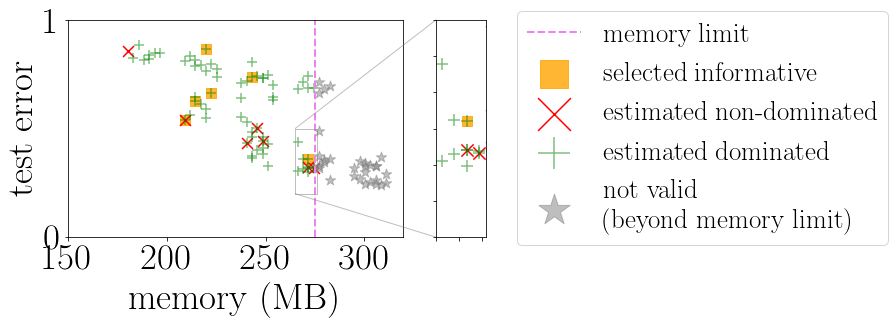

In [19]:
#auto inset box

fontsize = 37
fig, ax = plt.subplots()

ax.scatter(memory_single_selected, error_single_selected, s=90, color='orange', marker='s', alpha=.8, label='selected informative')
ax.scatter(memory_single_eff_pred, error_single_eff_pred, color='red', s=120, marker='x', alpha=1, label='estimated non-dominated')
ax.scatter(memory_single_non_eff_pred, error_single_non_eff_pred, color='green', s=120, marker='+', alpha=.5, label='estimated dominated')
ax.scatter(memory_single_not_valid, error_single_not_valid, color='gray', s=120, marker='*', alpha=.5, label='not valid \n (beyond memory limit)')

ax.set_xlabel("memory (MB)", fontsize=fontsize)
ax.set_ylabel("test error", fontsize=fontsize)
xtick_pos = [150, 200, 250, 300]
ytick_pos = [0, 1]
ax.axvline(memory_cap, color='violet', linestyle='dashed', linewidth=2, label='memory limit')
ax.legend(loc='lower left', bbox_to_anchor=(1.3, -.1), fontsize=fontsize-10, markerscale=3, ncol=1)

# inset axes
axins = ax.inset_axes([1.1, 0, 0.15, 1])
axins.scatter(memory_single_selected, error_single_selected, s=120, color='orange', marker='s', alpha=.8, label='selected informative')
axins.scatter(memory_single_eff_pred, error_single_eff_pred, color='red', s=150, marker='x', alpha=1, label='estimated non-dominated')
axins.scatter(memory_single_non_eff_pred, error_single_non_eff_pred, color='green', s=150, marker='+', alpha=.5, label='estimated dominated')
axins.scatter(memory_single_not_valid, error_single_not_valid, color='gray', s=150, marker='*', alpha=.5, label='not valid (beyond memory limit)')
# sub region of the original image
x1, x2, y1, y2 = 265, 276, 0.2, 0.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)

plt.xticks(xtick_pos, fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)